In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
import glob
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, guvectorize, float32, float64, boolean
import xrft
import dask


In [2]:
rootpath='/mnt/data04/model/CMAM/0A.daily/ERA5/'
name = 'himalayas'

In [3]:
#sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})
xr.set_options(keep_attrs=True,display_style='html')


# Functions

In [4]:
def get_ph_levs(level, sp):
    """Get the half-level pressures for the requested ERA5 model level and the one after that. The a and b coefficients
    define the model levels and are provided in `L137 model level definitions`_.
    Args:
        level (int): Model level identifier.
        sp (float): Surface pressure [Pa].
    Returns:
        tuple of float: Half-level pressures for the requested ERA5 model level and the one after that [Pa].
    .. _L137 model level definitions:
        https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels
    """

    a_coef = [0, 2.000365, 3.102241, 4.666084, 6.827977,9.746966, 13.605424, 18.608931, 24.985718, 32.98571,
        42.879242, 54.955463, 69.520576, 86.895882, 107.415741, 131.425507, 159.279404, 191.338562, 227.968948,
        269.539581, 316.420746, 368.982361, 427.592499, 492.616028, 564.413452, 643.339905, 729.744141, 823.967834,
        926.34491, 1037.201172, 1156.853638, 1285.610352, 1423.770142, 1571.622925, 1729.448975, 1897.519287,
        2076.095947, 2265.431641, 2465.770508, 2677.348145, 2900.391357, 3135.119385, 3381.743652, 3640.468262,
        3911.490479, 4194.930664, 4490.817383, 4799.149414, 5119.89502, 5452.990723, 5798.344727, 6156.074219,
        6526.946777, 6911.870605, 7311.869141, 7727.412109, 8159.354004, 8608.525391, 9076.400391, 9562.682617,
        10065.978516, 10584.631836, 11116.662109, 11660.067383, 12211.547852, 12766.873047, 13324.668945, 13881.331055,
        14432.139648, 14975.615234, 15508.256836, 16026.115234, 16527.322266, 17008.789063, 17467.613281, 17901.621094,
        18308.433594, 18685.71875, 19031.289063, 19343.511719, 19620.042969, 19859.390625, 20059.931641, 20219.664063,
        20337.863281, 20412.308594, 20442.078125, 20425.71875, 20361.816406, 20249.511719, 20087.085938, 19874.025391,
        19608.572266, 19290.226563, 18917.460938, 18489.707031, 18006.925781, 17471.839844, 16888.6875, 16262.046875,
        15596.695313, 14898.453125, 14173.324219, 13427.769531, 12668.257813, 11901.339844, 11133.304688, 10370.175781,
        9617.515625, 8880.453125, 8163.375, 7470.34375, 6804.421875, 6168.53125, 5564.382813, 4993.796875, 4457.375,
        3955.960938, 3489.234375, 3057.265625, 2659.140625, 2294.242188, 1961.5, 1659.476563, 1387.546875, 1143.25,
        926.507813, 734.992188, 568.0625, 424.414063, 302.476563, 202.484375, 122.101563, 62.78125, 22.835938, 3.757813,
        0, 0]

    b_coef = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        7e-06, 2.4e-05, 5.9e-05, 0.000112, 0.000199, 0.00034, 0.000562, 0.00089, 0.001353, 0.001992,
        0.002857, 0.003971, 0.005378, 0.007133, 0.009261, 0.011806, 0.014816, 0.018318, 0.022355, 0.026964,
        0.032176, 0.038026, 0.044548, 0.051773, 0.059728, 0.068448, 0.077958, 0.088286, 0.099462, 0.111505,
        0.124448, 0.138313, 0.153125, 0.16891, 0.185689, 0.203491, 0.222333, 0.242244, 0.263242, 0.285354,
        0.308598, 0.332939, 0.358254, 0.384363, 0.411125, 0.438391, 0.466003, 0.4938, 0.521619, 0.549301,
        0.576692, 0.603648, 0.630036, 0.655736, 0.680643, 0.704669, 0.727739, 0.749797, 0.770798, 0.790717,
        0.809536, 0.827256, 0.843881, 0.859432, 0.873929, 0.887408, 0.8999, 0.911448, 0.922096, 0.931881,
        0.94086, 0.949064, 0.95655, 0.963352, 0.969513, 0.975078, 0.980072, 0.984542, 0.9885, 0.991984,
        0.995003, 0.99763, 1]


    ph_lev = a_coef[level - 1] + (b_coef[level - 1] * sp)
    ph_levplusone = a_coef[level] + (b_coef[level] * sp)
    return ph_lev, ph_levplusone

def compute_level_height(t, q, level, ph_lev, ph_levplusone, h_h):
    """Compute height at half- & full-level for the requested ERA5 model level, based on temperature, humidity, and
    half-level pressures.
    Args:
        t (float): Temperature at the requested model level [K].
        q (float): Humidity at the requested model level [kg/kg].
        level (int): Model level identifier.
        ph_lev (float): Half-level pressure for the requested model level [Pa].
        ph_levplusone (float): Half-level pressures for the subsequent model level [Pa].
        h_h (float): Half-level height of previous model level [m].
    Returns:
        tuple of float: Half- and full-level heights of requested model level.
    """
    # Compute the moist temperature.
    t = t * (1. + 0.609133 * q)

    if level == 1:
        dlog_p = np.log(ph_levplusone / 0.1)
        alpha = np.log(2)
    else:
        dlog_p = np.log(ph_levplusone / ph_lev)
        alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)

    # Integrate from previous (lower) half-level h_h to the full-level.
    h_f = h_h + (t * r_d * alpha)/g

    # Integrate from previous (lower) half-level h_h to the current half-level.
    h_h = h_h + (t * r_d * dlog_p)/g

    return h_h, h_f
                      
def compute_level_heights(ds):
    #print('in', ds['t'].shape)
    levels = ds['level'].values
    n_levels = len(levels)
    h_h = 0  # Half-level height at lower model level.
    i_hr = 0

    height_ls = []
    density_ls = []
    for i, level in enumerate(reversed(levels)):  # Start from lower model level.
        #print(level)
        i_level = n_levels - 1 - i  # Identifier of model level.

        # Get the half-level pressures.
        ph_lev, ph_levplusone = get_ph_levs(level, np.exp(ds['lnsp']))

        # Determine half- & full-level height using previous half-level height.
        h_h, h_f = compute_level_height(ds['t'].isel(level = i_level), ds['q'].isel(level = i_level),
                                        level, ph_lev, ph_levplusone, h_h)
        h_f['level'] = i_level+1
        #print(i_level)
        #print(h_f.level)
        height_ls.append(h_f.expand_dims(['level'])) # 'time',

        pf = (ph_lev+ph_levplusone)/2  # Full-level pressure.
        #density_ls.append((pf/(r_d*ds['t'].isel(level = i_level))).expand_dims(['level'])) # 'time',

    chunk_dict = {'level':-1}
    da_height = xr.concat(height_ls, dim = 'level').chunk(chunk_dict)
    da_height.name = 'h'
    da_height.attrs['units'] = 'metres'
    da_height.attrs['long_name'] = 'geopotential height'

    """    
    da_density = xr.concat(density_ls, dim = 'level').chunk(chunk_dict)
    da_density.name = 'rho'
    da_density.attrs['units'] = 'kg/m^3'
    da_density.attrs['long_name'] = 'density'
    """

    ds_out = xr.merge([ds[['w','u']], # .expand_dims('time')
                       da_height.transpose('time', ...)])
    print('out', ds_out['t'].shape)
    return ds_out

def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]
  
@guvectorize(
    [
        (float64[:], float64[:], float64[:], boolean, float64[:]),
        (float32[:], float32[:], float32[:], boolean, float32[:]),
    ],
    "(n),(n),(m),()->(m)",
    nopython=True,
)
def _interp_1d_linear(phi, theta, target_theta_levels, mask_edges, output):
    # if last theta value is smaller than first, assume the profile is monotonically decreasing and flip
    if theta[-1] < theta[0]:
        theta = np.flip(theta)
        phi = np.flip(phi)

    output[:] = np.interp(target_theta_levels, theta, phi)

    if mask_edges:
        theta_max = np.nanmax(theta)
        theta_min = np.nanmin(theta)
        for i in range(len(target_theta_levels)):
            theta_lev = target_theta_levels[i]
            if (theta_lev < theta_min) or (theta_lev > theta_max):
                output[i] = np.nan


def interp_1d_linear(phi, theta, target_theta_levels, mask_edges=True):
    """
    Vectorized interpolation of scalar phi to isosurfaces of scalar theta
    along the final axis.
    Parameters
    ----------
    phi : array_like
        Array of shape (..., n), scalar field to be interpolated
    theta : array_like
        Array of shape (..., n), scalar field which defines the isosurfaces
    target_theta_levels : array_like
        Array of shape (m) specificying target isosurface levels
    mask_edges : bool, optional
        Determines how to handle theta values that exceed the bounds of
        target_theta_levels. If False, fill with nearest valid values. If
        True, fill with NaNs.
    Returns
    -------
    phi_interp : array
        Array of shape (..., m) of phi interpolated to theta isosurfaces.
    """
    return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


def linear_interpolation(
    phi, theta, target_theta_levels, phi_dim, theta_dim, target_dim, **kwargs):
    out = xr.apply_ufunc(
        interp_1d_linear,
        phi,
        theta,
        target_theta_levels,
        kwargs=kwargs,
        input_core_dims=[[phi_dim], [theta_dim], [target_dim]],
        output_core_dims=[[target_dim]],
        exclude_dims=set((phi_dim,)),
        dask="parallelized",
        output_dtypes=[np.float32],
        dask_gufunc_kwargs = dict(allow_rechunk=True),
    )
    out[target_dim] = target_theta_levels
    return out

def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

def unstack_ds(ds):
    temp = ds.stack(time2 = ('time','step'))
    temp['time2'] = ds.valid_time.values.flatten()
    temp = temp.reset_coords(drop = True).rename({'time2':'time'})
    return temp

In [5]:
client = Client(LocalCluster(host='195.113.23.121')) # 
client

Client Scheduler: tcp://195.113.23.121:42311 Dashboard: http://195.113.23.121:8787/status,Cluster Workers: 8 Cores: 64 Memory: 503.57 GiB


# Open data

## Wind 

In [5]:
infiles = f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_lnsp_*.grib'
ds_sfc = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    backend_kwargs={'filter_by_keys': {'shortName': 'lnsp'}},
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    chunks = {'time': 1}
)
ds_sfc

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440, time: 180)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-16 ... 2010-02-13T18:00:00
    step        timedelta64[ns] 00:00:00
    hybrid      float64 1.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    lnsp        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-17T14:48 GRIB to CDM+CF via cfgrib-0.9.9...

In [5]:
infiles = f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_ml_*.grib'
ds_u = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={'filter_by_keys': {'shortName': 'u'}},
    chunks = {'time': 1},
)
ds_w = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={'filter_by_keys': {'shortName': 'w'}},
    chunks = {'time': 1}
)
ds = xr.merge([ds_u, ds_w])
ds = ds.rename({'hybrid':'level'})
ds['level'] = np.int32(ds.level)
ds

<xarray.Dataset>
Dimensions:     (latitude: 721, level: 137, longitude: 1440, time: 180)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-16 ... 2010-02-13T18:00:00
    step        timedelta64[ns] 00:00:00
  * level       (level) int32 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    u           (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 137, 721, 1440), meta=np.ndarray>
    w           (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 137, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-17T13:46 GRIB to CDM+CF via cfgrib-0.9.9...

In [8]:
ds.reset_coords(drop=True).to_zarr(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_ml.zarr')

In [5]:
ds = xr.open_zarr(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_ml.zarr')
ds

,Array,Chunk
Bytes,95.38 GiB,542.60 MiB
Shape,"(180, 137, 721, 1440)","(1, 137, 721, 1440)"
Count,181 Tasks,180 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,95.38 GiB,542.60 MiB
Shape,"(180, 137, 721, 1440)","(1, 137, 721, 1440)"
Count,181 Tasks,180 Chunks
Type,float32,numpy.ndarray


## GWD

In [58]:
len(sorted(glob.glob(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_GWDlnsp_*.grib')))

43

In [15]:
infiles = sorted(glob.glob(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_GWDlnsp_*.grib'))#[:2]
step_slice = slice(1,-1,4)
ds_sfc = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={
        'filter_by_keys': {'shortName': 'lnsp'},
                   },
    chunks = {'time': 1},
)
ds_sfc = unstack_ds(ds_sfc.isel(step = step_slice))
#ds_sfc = ds_sfc.chunk({'time': 1})
ds_sfc

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 258)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-16T07:00:00 ... 2010-02-14T03:00:00
Data variables:
    lnsp       (latitude, longitude, time) float32 dask.array<chunksize=(721, 1440, 3), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-18T22:41 GRIB to CDM+CF via cfgrib-0.9.9...

In [57]:
len(sorted(glob.glob(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_GWDml_*.grib')))

45

In [14]:
infiles = sorted(glob.glob(f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_GWDml_*.grib'))#[:2]
#print(infiles)
ds = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={
        'filter_by_keys': {'shortName': 'mutpm'},
                   },
    chunks = {'time': 1},
)
ds = unstack_ds(ds.isel(step = step_slice))
ds = ds.rename({'hybrid':'level'})
ds['level'] = np.int32(ds.level)
#ds = ds.chunk({'time': 1})
ds

,Array,Chunk
Bytes,143.07 GiB,1.59 GiB
Shape,"(137, 721, 1440, 270)","(137, 721, 1440, 3)"
Count,495 Tasks,90 Chunks
Type,float32,numpy.ndarray


In [22]:
ds.to_zarr(f'{rootpath}GWD_ERA5_{name}_events_4hourly_ml.zarr')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 40.31 GiB -- Worker memory limit: 62.95 GiB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 42.91 GiB -- Worker memory limit: 62.95 GiB


In [6]:
ds = xr.open_zarr(f'{rootpath}GWD_ERA5_{name}_events_4hourly_ml.zarr')
ds

,Array,Chunk
Bytes,143.07 GiB,1.59 GiB
Shape,"(137, 721, 1440, 270)","(137, 721, 1440, 3)"
Count,91 Tasks,90 Chunks
Type,float32,numpy.ndarray


In [87]:
infiles = f'{rootpath}u-w-lnsp_ERA5_{name}_events_6hourly_GWDml_*.grib'
ds_gwd = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={
        'filter_by_keys': {'shortName': 'mutpm'},
        'typeOfLevel': 'hybrid'
                   },
    #chunks = {'time': 1},
)

KeyboardInterrupt: 

# Interpolation

In [16]:
levels = ds['level'].values
n_levels = len(levels)
h_h = 0  # Half-level height at lower model level.
i_hr = 0

height_ls = []
density_ls = []
p_ls = []
for i, level in enumerate(reversed(levels)):  # Start from lower model level.
    #print(level)
    i_level = n_levels - 1 - i  # Identifier of model level.

    # Get the half-level pressures.
    ph_lev, ph_levplusone = get_ph_levs(level, np.exp(ds_sfc['lnsp']))
    pf = (ph_lev+ph_levplusone)/2  # Full-level pressure.
    p_ls.append(pf)

pressure = xr.concat(p_ls, dim = 'level')
pressure['level'] = ds['level'][::-1]
pressure.attrs['units'] = 'Pa'
pressure

,Array,Chunk
Bytes,136.71 GiB,11.88 MiB
Shape,"(137, 721, 1440, 258)","(1, 721, 1440, 3)"
Count,66779 Tasks,11782 Chunks
Type,float32,numpy.ndarray


In [9]:
pressure.to_dataset().to_zarr(f'{rootpath}lnsp_ERA5_{name}_events_6hourly_ml.zarr')

In [17]:
pressure.to_dataset().to_zarr(f'{rootpath}GWDlnsp_ERA5_{name}_events_6hourly_ml.zarr')

In [7]:
ds_lnsp = xr.open_zarr(f'{rootpath}GWDlnsp_ERA5_{name}_events_6hourly_ml.zarr')
pressure = ds_lnsp['lnsp']
pressure

,Array,Chunk
Bytes,136.71 GiB,11.88 MiB
Shape,"(137, 721, 1440, 258)","(1, 721, 1440, 3)"
Count,11783 Tasks,11782 Chunks
Type,float32,numpy.ndarray


In [9]:
# 1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
#        750.,  700.,  650.,  600.,  550., 
arr = np.array([500.,  450.,  400.,  350.,  300.,
        250.,  225.,  200.,  175.,  150.,  125.,  100.,   70.,   50.,   30.,
         20.,   10.,    7.,    5.,    3.,    2.,    1., 
         .70,   .50,   .30, .20,   .10])
alt = xr.DataArray(arr*100., 
                   dims = ['plev'],
                   attrs = dict(units = 'Pa',
                                long_name = 'pressure'))
vert_c_name = 'level'
# ,'w' , 'uw'
ds_out = linear_interpolation(ds[['mutpm']].reset_coords(drop=True).sel(time = pressure.time), 
                              pressure.sortby('level').reset_coords(drop=True), 
                              alt,
                              vert_c_name, 
                              vert_c_name, 
                              'plev')

ds_out['plev'] = ds_out.plev/100.
ds_out['plev'].attrs['units'] = 'hPa'
ds_out

,Array,Chunk
Bytes,26.94 GiB,320.81 MiB
Shape,"(721, 1440, 258, 27)","(721, 1440, 3, 27)"
Count,35869 Tasks,86 Chunks
Type,float32,numpy.ndarray


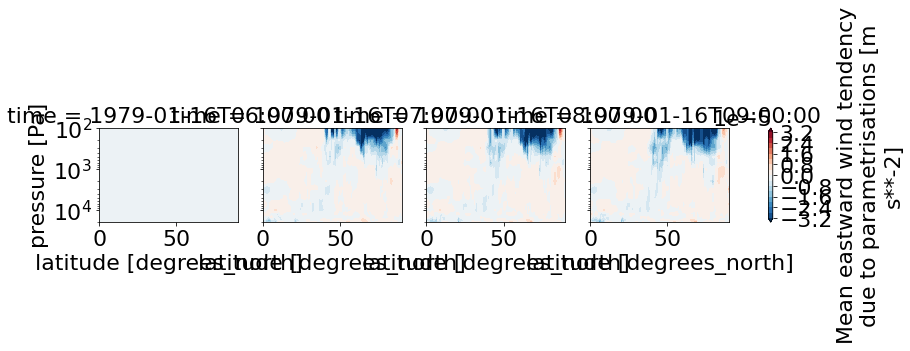

In [50]:
ds_out['mutpm'].sel(
    latitude = slice(None,0),
    plev = slice(20000,100),
).isel(
    time = slice(None,4)
).mean('longitude').plot.contourf(
            yincrease = False, 
            robust = True,
            extend = 'both',
            cmap = 'RdBu_r',
            x = 'latitude',
            col_wrap = 4,
            col = 'time',
            levels = 21
    )
plt.yscale('log')

In [10]:
ds_out.to_zarr(f'{rootpath}GWD_ERA5_{name}_events_6hourly_pl.zarr', mode = 'w')

In [13]:
ds_out.to_zarr(f'{rootpath}u-w_ERA5_{name}_events_6hourly_pl.zarr', mode = 'w')

distributed.worker - ERROR - failed during get data with tcp://195.113.23.121:40023 -> tcp://195.113.23.121:37003
Traceback (most recent call last):
  File "/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/tornado/iostream.py", line 867, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/tornado/iostream.py", line 1140, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/distributed/worker.py", line 1432, in get_data
    response = await comm.read(deserializers=serializers)
  File "/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/distributed/comm/tcp.py", line 206, in read
    convert_stream_closed_error(self, e)
  File "/home/kuchar/.conda/envs/moje/lib/python3.9/site

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


# VMFC calculation

In [14]:
ds_u = xr.open_zarr(f'{rootpath}u_ERA5_{name}_events_6hourly_pl.zarr')
ds_w = xr.open_zarr(f'{rootpath}w_ERA5_{name}_events_6hourly_pl.zarr')

In [16]:
u_fft = xrft.fft(ds_u['u'], dim = 'longitude')#, real_dim = 'longitude')     
w_fft = xrft.fft(ds_w['w'], dim = 'longitude')#, real_dim = 'longitude')

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [18]:
dask.config.set({"array.slicing.split_large_chunks": False}) 

In [20]:
nl  = ds_u.longitude.shape[0]**2
xyf = (u_fft*w_fft.conj()).real/nl
temp = xyf.sel(freq_longitude = slice(0,None))
zeros = xr.zeros_like(xyf)
zeros.loc[dict(freq_longitude=temp.freq_longitude.values[21:])] = 1
zeros.loc[dict(freq_longitude=-temp.freq_longitude.values[21:])] = 1

temp = xyf*zeros
temp_sum = temp.sum('freq_longitude')
#temp_sum['level'] = temp_sum.level*100. # already in Pascals

In [56]:
45*4

180

In [22]:
# convert hPa to Pa and then derivate
scaling = 24*2600
vmfc = (-temp_sum.differentiate('plev')*scaling).load()
vmfc['plev'] = vmfc.plev/100.
vmfc['plev'].attrs['units'] = 'hPa'
vmfc['plev'].attrs['long_name'] = 'pressure'
vmfc.attrs['units'] = 'm/s/day'
vmfc.attrs['long_name'] = 'vertical momentum flux convergence'
vmfc

<xarray.DataArray (time: 180, latitude: 721, plev: 27)>
array([[[ 2.91703233e-32,  2.43086027e-33, -1.21543014e-32, ...,
         -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [-1.80231780e-09, -7.45783521e-09,  6.16482584e-09, ...,
          1.51994476e-08,  1.67110217e-08, -1.09741028e-08],
        [-6.56116532e-10, -3.44533039e-09, -1.63471961e-09, ...,
          6.92501906e-09,  1.24485435e-08,  4.82185706e-09],
        ...,
        [ 6.66282674e-09,  3.41985633e-10, -4.60158264e-09, ...,
         -9.60852083e-09, -4.82320449e-09,  2.77905689e-09],
        [ 7.10713934e-09, -1.96283230e-09, -8.45782006e-09, ...,
          8.07224316e-09, -7.91711928e-09, -8.07361238e-09],
        [-7.59643835e-35, -3.79821917e-35, -3.79821917e-35, ...,
          5.93471746e-34,  5.95789995e-34,  4.63649801e-36]],

       [[ 4.86172054e-33, -0.00000000e+00, -2.46884246e-33, ...,
          6.33036529e-33, -0.00000000e+00, -9.49554793e-33],
        [-9.78196373e-09, -3.94267019e-09,  1.80211173e-10, ...,
          4.62499119e-09,  6.79544974e-09, -4.35909498e-09],
        [ 1.57762518e-08,  7.11608080e-09, -6.89532446e-09, ...,
         -1.42484046e-08, -4.82287153e-09,  1.39421497e-08],
...
        [ 4.38961961e-08, -1.70916165e-09, -2.93871825e-08, ...,
          5.55581067e-10, -6.37831185e-10, -4.75886272e-10],
        [ 2.32207304e-08,  6.42687794e-09,  3.12108236e-09, ...,
         -1.04719848e-09,  1.66982159e-09, -3.98314090e-10],
        [-2.43086027e-33, -1.21543014e-33, -0.00000000e+00, ...,
         -7.91295661e-34, -0.00000000e+00,  1.18694349e-33]],

       [[-2.43086027e-33, -6.07715068e-34,  5.88723972e-34, ...,
          9.81206620e-32,  9.02077054e-32, -9.49554793e-33],
        [ 2.05495965e-08,  7.52288600e-09, -7.66554038e-09, ...,
         -2.34185419e-09, -2.36384627e-09,  4.81467868e-10],
        [-1.84925736e-08, -4.09963879e-09,  6.99977975e-09, ...,
         -4.00145124e-10, -3.62774021e-09,  1.33506010e-09],
        ...,
        [-5.09845419e-09,  3.32828725e-09,  3.86197636e-09, ...,
          3.07687273e-09,  2.17180997e-09, -3.55516147e-10],
        [ 2.80034138e-08, -1.06582851e-09, -1.02795762e-09, ...,
          2.22689853e-09,  3.56472484e-09,  1.72394252e-09],
        [-2.43086027e-33, -1.82314520e-33,  6.07715068e-34, ...,
         -7.91295661e-34, -5.93471746e-34,  5.93471746e-34]]])
Coordinates:
  * latitude  (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * plev      (plev) float64 500.0 450.0 400.0 350.0 300.0 ... 0.5 0.3 0.2 0.1
  * time      (time) datetime64[ns] 1979-01-16 ... 2010-02-13T18:00:00
Attributes:
    units:      m/s/day
    long_name:  vertical momentum flux convergence

In [36]:
vmfc.to_dataset(name = 'vmfc').to_netcdf(f'{rootpath}vmfc_ERA5_{name}_events_6hourly_pl.nc')

In [62]:
37*4

148

## Visualization

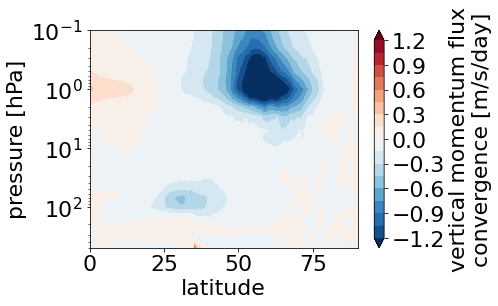

In [68]:
p = vmfc.mean('time').sel(
    latitude = slice(None,0)
    ).squeeze().plot.contourf(
            yincrease = False, 
            robust = True,
            extend = 'both',
            cmap = 'RdBu_r',
            x = 'latitude',
    levels = 21
    )
plt.yscale('log')


In [71]:
p.colorbar.get_ticks()

array([-1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2])

In [72]:
p.colorbar.values

array([-5.000e+249, -1.125e+000, -9.750e-001, -8.250e-001, -6.750e-001,
       -5.250e-001, -3.750e-001, -2.250e-001, -7.500e-002,  7.500e-002,
        2.250e-001,  3.750e-001,  5.250e-001,  6.750e-001,  8.250e-001,
        9.750e-001,  1.125e+000,  5.000e+249])

### Only DJF

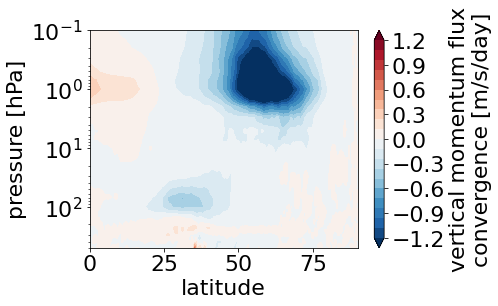

In [74]:
mask = np.isin(vmfc.time.dt.month, [12,1,2])
vmax = p.colorbar.vmax
vmfc.sel(
    time = mask,
    latitude = slice(None,0)
    ).mean('time').squeeze().plot.contourf(
            yincrease = False, 
            vmax = vmax,
            vmin = -vmax,
            extend = 'both',
            cmap = 'RdBu_r',
            x = 'latitude',
            levels = 21,
            cbar_kwargs = dict(ticks = p.colorbar.get_ticks())
    )
plt.yscale('log')

# Comparison with CMAM30-SD

In [14]:
ds_vmfc=xr.open_dataset(f'{rootpath}vmfc_ERA5_{name}_events_6hourly_pl.nc')
vmfc = ds_vmfc['vmfc']
vmfc

<xarray.DataArray 'vmfc' (time: 180, latitude: 721, plev: 27)>
[3504060 values with dtype=float64]
Coordinates:
  * latitude  (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * plev      (plev) float64 500.0 450.0 400.0 350.0 300.0 ... 0.5 0.3 0.2 0.1
  * time      (time) datetime64[ns] 1979-01-16 ... 2010-02-13T18:00:00
Attributes:
    units:      m/s/day
    long_name:  vertical momentum flux convergence

In [12]:
ds_gwd = xr.open_zarr(f'{rootpath}GWD_ERA5_{name}_events_6hourly_pl.zarr')
ds_gwd

,Array,Chunk
Bytes,26.94 GiB,320.81 MiB
Shape,"(721, 1440, 258, 27)","(721, 1440, 3, 27)"
Count,87 Tasks,86 Chunks
Type,float32,numpy.ndarray


## Anomalies

In [34]:
sel_var = 'accelogw'
DJF_bool = '_DJFonly'
cesta = f'{rootpath}/../composites_woSSW{DJF_bool}/'
infile = f'{cesta}{sel_var}_anomalies_comp_himalayas_20days.nc'
print(infile)
ds_comp = xr.open_dataset(infile)
ds_comp

/mnt/data04/model/CMAM/0A.daily/ERA5//../composites_woSSW_DJFonly/accelogw_anomalies_comp_himalayas_20days.nc


<xarray.Dataset>
Dimensions:   (lag: 21, lat: 48, lon: 96, plev: 63)
Coordinates:
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 8e+04 ... 0.2 0.15 0.1 0.07
  * lat       (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lag       (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    accelogw  (lag, plev, lat, lon) float64 ...

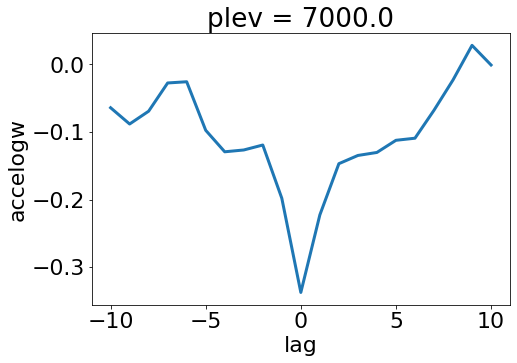

In [32]:
p = (ds_comp['accelogw']*scaling).sel(
    lat = slice(20,40),
    plev = 7000
).mean(['lat','lon']).plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

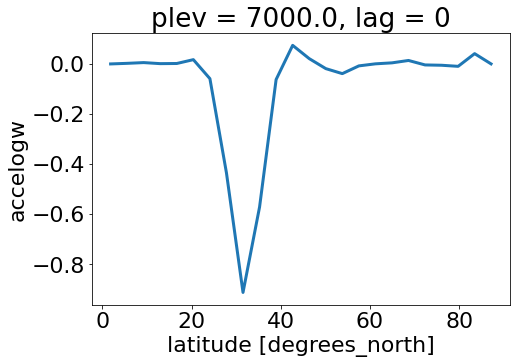

In [36]:
p = (ds_comp['accelogw']*scaling).sel(
    lat = slice(0,None),
    lag = 0,
    plev = 7000
).mean(['lon']).plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

## Absolute

In [33]:
sel_var = 'accelogw'
DJF_bool = '_DJFonly'
cesta = f'{rootpath}/../composites_woSSW{DJF_bool}/'
infile = f'{cesta}{sel_var}_absolute_comp_himalayas_20days.nc'
print(infile)
ds_comp = xr.open_dataset(infile)
ds_comp

/mnt/data04/model/CMAM/0A.daily/ERA5//../composites_woSSW_DJFonly/accelogw_absolute_comp_himalayas_20days.nc


<xarray.Dataset>
Dimensions:   (lag: 21, lat: 48, lon: 96, plev: 63)
Coordinates:
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 8e+04 ... 0.2 0.15 0.1 0.07
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat       (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lag       (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    accelogw  (lag, plev, lat, lon) float32 ...

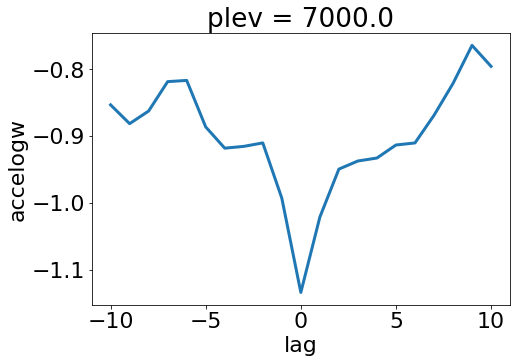

In [30]:
p = (ds_comp['accelogw']*scaling).sel(
    lat = slice(20,40),
    plev = 7000
).mean(['lat','lon']).plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

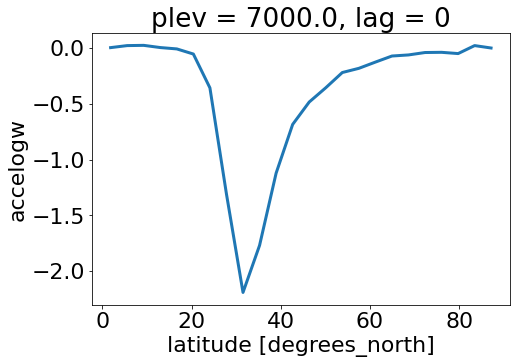

In [27]:
p = (ds_comp['accelogw']*scaling).sel(
    lag = 0,
    lat = slice(0,None),
    plev = 7000
).mean('lon').plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

Text(0, 0.5, 'u-tendency [m/s/day]')

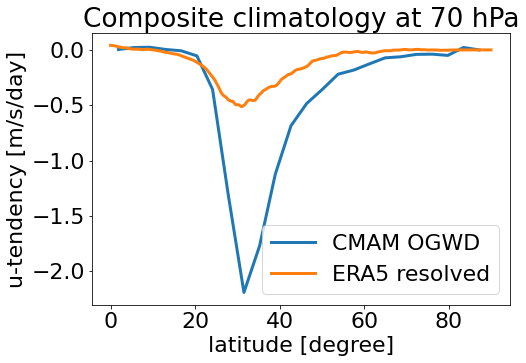

In [25]:
p = (ds_comp['accelogw']*scaling).sel(
    lag = 0,
    lat = slice(0,None),
    plev = 7000
).mean('lon').plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

ax = p[0].axes

vmfc.mean('time').sel(
    latitude = slice(None,0),
    plev = 70
    ).plot(
    ax = ax, 
    label = 'ERA5 resolved',
    lw = 3
    )
ax.legend()
ax.set_title('Composite climatology at 70 hPa')
ax.set_xlabel('latitude [degree]')
ax.set_ylabel('u-tendency [m/s/day]')

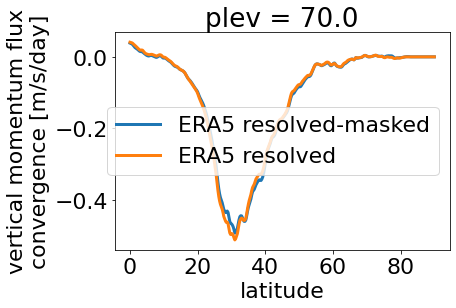

In [15]:
mask = np.isin(vmfc.time.dt.month, [12,1,2])
p = vmfc.sel(
    latitude = slice(None,0),
    time = mask,
    plev = 70
    ).mean('time').plot(
    label = 'ERA5 resolved-masked',
    lw = 3
    )
ax = p[0].axes
vmfc.sel(
    latitude = slice(None,0),
    plev = 70
    ).mean('time').plot(
    ax = ax, 
    label = 'ERA5 resolved',
    lw = 3
    )
ax.legend()


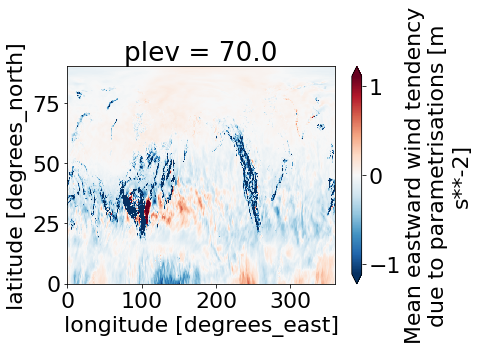

In [24]:
(ds_gwd['mutpm']*scaling).sel(
    latitude = slice(None,0),
    time = mask,
    plev = 70
    ).mean(['time']).plot(robust = True)

Text(0, 0.5, 'u-tendency [m/s/day]')

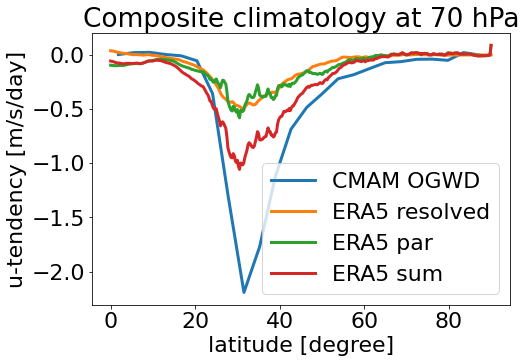

In [21]:
scaling = 24*3600
p = (ds_comp['accelogw']*scaling).sel(
    lag = 0,
    lat = slice(0,None),
    plev = 7000
).mean('lon').plot(
    size = 5,
    label = 'CMAM OGWD',
    lw = 3
)

ax = p[0].axes

mask = np.isin(vmfc.time.dt.month, [12,1,2])
temp1 = vmfc.sel(
    latitude = slice(None,0),
    time = mask,
    plev = 70
    ).mean('time')
temp1.plot(
    ax = ax, 
    label = 'ERA5 resolved',
    lw = 3
    )


mask = np.isin(ds_gwd.time.dt.month, [12,1,2])
temp2 = (ds_gwd['mutpm']*scaling).sel(
    latitude = slice(None,0),
    time = mask,
    plev = 70
    ).mean(['time','longitude'])
temp2.plot(
    ax = ax, 
    label = 'ERA5 par',
    lw = 3
    )

(temp1+temp2).plot(
    ax = ax, 
    label = 'ERA5 sum',
    lw = 3
    )

ax.legend()
ax.set_title('Composite climatology at 70 hPa')
ax.set_xlabel('latitude [degree]')
ax.set_ylabel('u-tendency [m/s/day]')